## Import necessary Libraries

In [49]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## 1. Dataset Loading and Understanding


In [50]:
data =pd.read_csv('AI-Powered Content Analysis and Recommendation.csv')

In [51]:
data.head()

,title,text,url,authors,timestamp,tags
0,Mental Note Vol. 24,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,https://medium.com/invisible-illness/mental-no...,['Ryan Fan'],2020-12-26 03:38:10.479000+00:00,"['Mental Health', 'Health', 'Psychology', 'Sci..."
1,Your Brain On Coronavirus,Your Brain On Coronavirus\n\nA guide to the cu...,https://medium.com/age-of-awareness/how-the-pa...,['Simon Spichak'],2020-09-23 22:10:17.126000+00:00,"['Mental Health', 'Coronavirus', 'Science', 'P..."
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,https://medium.com/neodotlife/mind-your-nose-f...,[],2020-10-10 20:17:37.132000+00:00,"['Biotechnology', 'Neuroscience', 'Brain', 'We..."
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,['Eshan Samaranayake'],2020-12-21 16:05:19.524000+00:00,"['Health', 'Neuroscience', 'Mental Health', 'P..."
4,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology..."


In [52]:
data.size


1154208

In [53]:
data.shape


(192368, 6)

In [54]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192368 entries, 0 to 192367
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   title      192363 non-null  object
 1   text       192368 non-null  object
 2   url        192368 non-null  object
 3   authors    192368 non-null  object
 4   timestamp  192366 non-null  object
 5   tags       192368 non-null  object
dtypes: object(6)
memory usage: 8.8+ MB


In [55]:
# Sample of unique authors (first 10)
data['authors'].unique()[:10]

# Sample of unique tags (first 10)
data['tags'].unique()[:10]

array(["['Mental Health', 'Health', 'Psychology', 'Science', 'Neuroscience']",
       "['Mental Health', 'Coronavirus', 'Science', 'Psychology', 'Neuroscience']",
       "['Biotechnology', 'Neuroscience', 'Brain', 'Wellness', 'Science']",
       "['Health', 'Neuroscience', 'Mental Health', 'Psychology', 'Science']",
       "['Brain', 'Health', 'Development', 'Psychology', 'Science']",
       "['Society', 'Mental Health', 'Health', 'Nonfiction', 'Coronavirus']",
       "['Books', 'Entrepreneurship', 'Writing', 'Marketing', 'Productivity']",
       "['People', 'Storyfest', 'Health', 'Pakistan', 'Storytelling']",
       "['Self Improvement', 'Mental Health', 'Health', 'Wellness', 'Science']",
       "['Machine Learning', 'Science', 'Neuroscience', 'Psychology', 'Artificial Intelligence']"],
      dtype=object)

In [56]:
from collections import Counter
import ast

In [57]:
# Convert string list to actual list and flatten the authors
authors_flat = [author.strip() for sublist in data['authors'].apply(ast.literal_eval) for author in sublist]
author_counts = Counter(authors_flat)

In [58]:
# Display top 10 most frequent authors
author_counts.most_common(10)

[('Are You Syrious', 206),
 ('John Au-Yeung', 167),
 ('The Good Men Project', 155),
 ('J.D. Harms', 152),
 ('Scott Myers', 143),
 ('Gaurav Shah', 138),
 ('Tds Editors', 124),
 ('Shamontiel L. Vaughn', 122),
 ('Martino Pietropoli', 115),
 ('James Finn', 114)]

In [59]:
# Flatten and count tags
tags_flat = [tag.strip() for sublist in data['tags'].apply(ast.literal_eval) for tag in sublist]
tag_counts = Counter(tags_flat)

# Display top 10 tags
tag_counts.most_common(10)

[('Blockchain', 7534),
 ('Data Science', 7410),
 ('Technology', 6384),
 ('Programming', 6364),
 ('Poetry', 6336),
 ('Cryptocurrency', 6245),
 ('Machine Learning', 6055),
 ('Life', 5954),
 ('Bitcoin', 5800),
 ('Writing', 5115)]

In [60]:
# Check how many failed
print("Invalid timestamps:", data['timestamp'].isna().sum())


Invalid timestamps: 2


In [61]:
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
data['timestamp'].dt.year.value_counts().sort_index()


timestamp
2014.0         1
2015.0       635
2016.0      2687
2017.0      4641
2018.0      9810
2019.0     26159
2020.0    115643
2021.0     32108
2022.0       271
Name: count, dtype: int64

##  2.Data Cleaning & Preprocessing

### 2.1: Handle Missing Values

In [62]:
data.isnull().sum()


title          5
text           0
url            0
authors        0
timestamp    413
tags           0
dtype: int64

In [63]:
# Drop rows where timestamp could not be parsed
data = data[~data['timestamp'].isnull()]


In [64]:
# Fill missing titles/text with a placeholder
data['title'] = data['title'].fillna('No Title')
data['text'] = data['text'].fillna('No Content')


### 2.2: Detect and Manage Outliers

In [65]:
# Add column for text length
data['text_length'] = data['text'].apply(lambda x: len(str(x)))

# Use IQR to detect outliers in text length
Q1 = data['text_length'].quantile(0.25)
Q3 = data['text_length'].quantile(0.75)
IQR = Q3 - Q1

# Outlier condition
outliers = data[(data['text_length'] < (Q1 - 1.5 * IQR)) | (data['text_length'] > (Q3 + 1.5 * IQR))]

# Optionally, remove them
data = data[~data.index.isin(outliers.index)]


### 2.3: Standardize  Numerical Data

In [66]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['text_length_scaled'] = scaler.fit_transform(data[['text_length']])


### 2.4: Encode Categorical Variables

In [67]:
import ast

# Convert stringified lists into actual lists
data['authors'] = data['authors'].apply(ast.literal_eval)
data['tags'] = data['tags'].apply(ast.literal_eval)


In [68]:

data['joined_tags'] = data['tags'].apply(lambda tags: ' '.join(tags))


In [69]:
# Use only the first author for label encoding
data['primary_author'] = data['authors'].apply(lambda x: x[0] if len(x) > 0 else 'Unknown')

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['author_encoded'] = le.fit_transform(data['primary_author'])


In [70]:
data.to_csv('cleaned_data.csv', index=False)


## 3.Exploratory Data Analysis (EDA)

### 3.1: Summary Statistics

In [71]:
# Summary statistics
data['text_length'].describe()

# Additional metrics
print("Skewness:", data['text_length'].skew())
print("Kurtosis:", data['text_length'].kurtosis())


Skewness: 0.8371868342579237
Kurtosis: 0.11294464924674719


### 3.2: Correlation Matrix

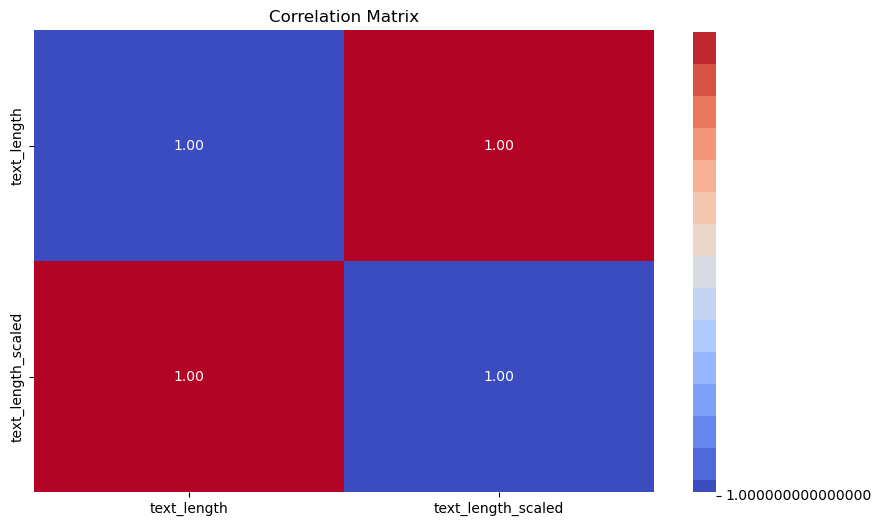

In [72]:
# Only select numerical columns
numerical_cols = data.select_dtypes(include=['int64', 'float64'])

# Correlation matrix
correlation_matrix = numerical_cols.corr()

# Visualize
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


###  3.3 Class Distribution & Imbalance

### (a) Authors:

<Axes: title={'center': 'Top 10 Authors'}, xlabel='primary_author'>

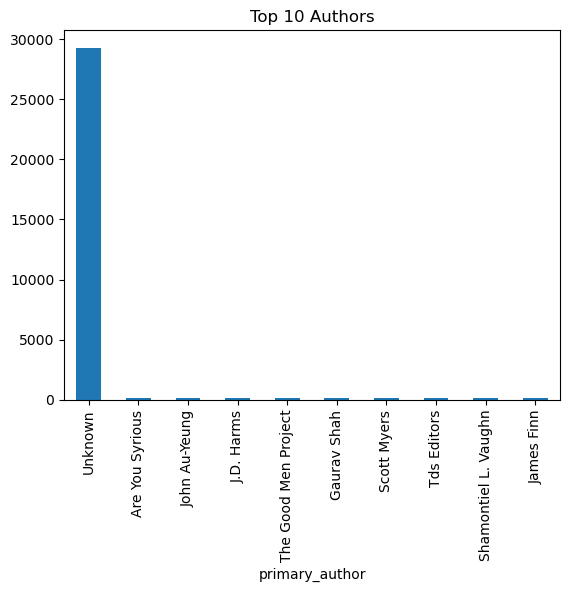

In [79]:
data['primary_author'].value_counts().head(10).plot(kind='bar', title='Top 10 Authors')


### (b) Tags (after one-hot or multilabel encoding):


In [83]:
import ast

# Helper function to safely evaluate stringified lists
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return []  # return empty list if it fails

# Apply safe conversion
data['tags'] = data['tags'].fillna("[]")  # fill missing with empty list
data['tags'] = data['tags'].apply(safe_literal_eval)



In [84]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb_tags = MultiLabelBinarizer()
tags_encoded = mlb_tags.fit_transform(data['tags'])
tags_df = pd.DataFrame(tags_encoded, columns=mlb_tags.classes_)

# Join back to original dataset
data = pd.concat([data.reset_index(drop=True), tags_df.reset_index(drop=True)], axis=1)


### (c) Articles per Year:

<Axes: title={'center': 'Articles Per Year'}, xlabel='timestamp'>

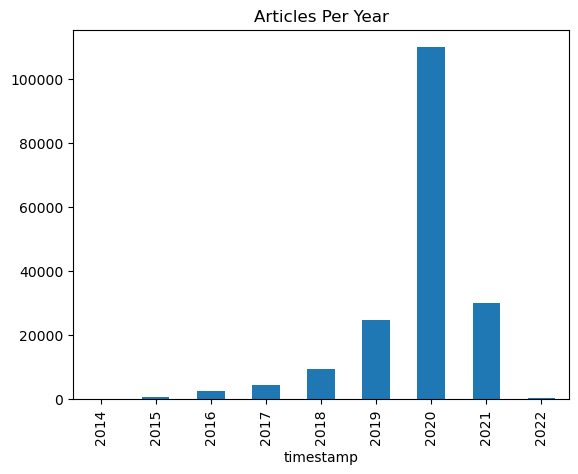

In [85]:
data['timestamp'].dt.year.value_counts().sort_index().plot(kind='bar', title='Articles Per Year')


## 4. Data Visualization & Insight Extraction

### Histogram – Text Length Distribution

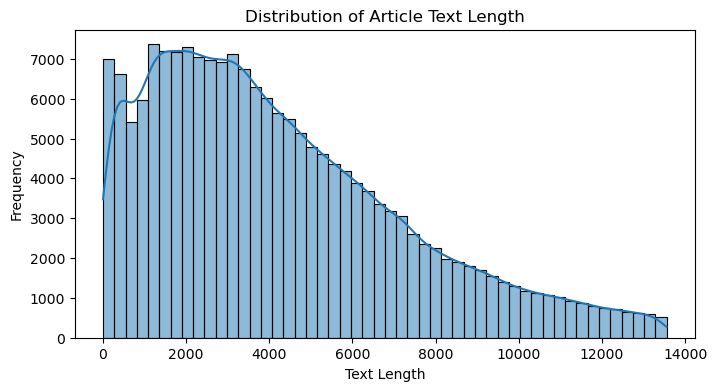

In [94]:
plt.figure(figsize=(8, 4))
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title("Distribution of Article Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()


## Box Plot – Text Length Outliers

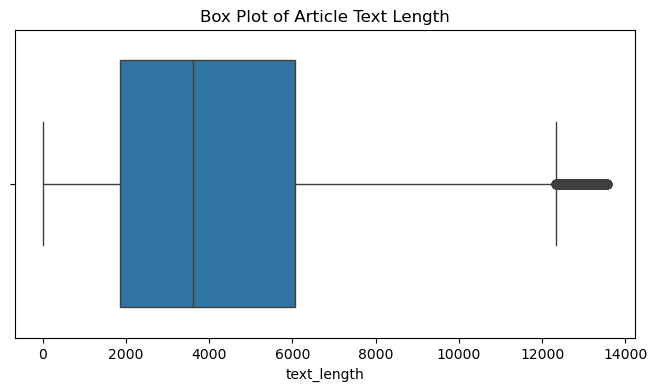

In [95]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=data['text_length'])
plt.title("Box Plot of Article Text Length")
plt.show()


## Scatter Plot – Text Length vs. Year

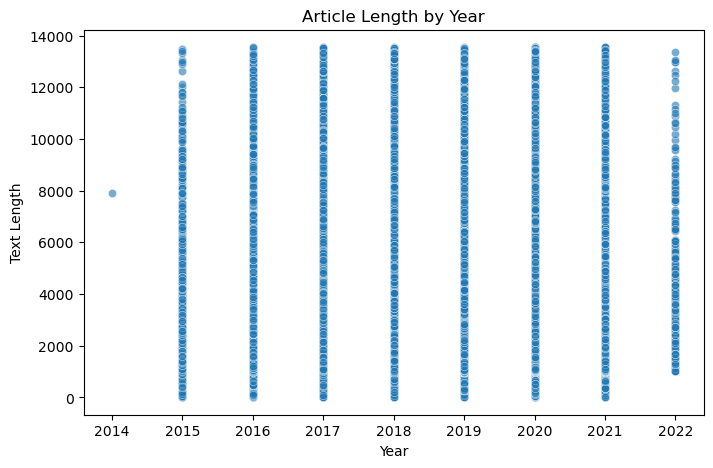

In [96]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x='year', y='text_length', data=data, alpha=0.6)
plt.title("Article Length by Year")
plt.xlabel("Year")
plt.ylabel("Text Length")
plt.show()


## Correlation Heatmap

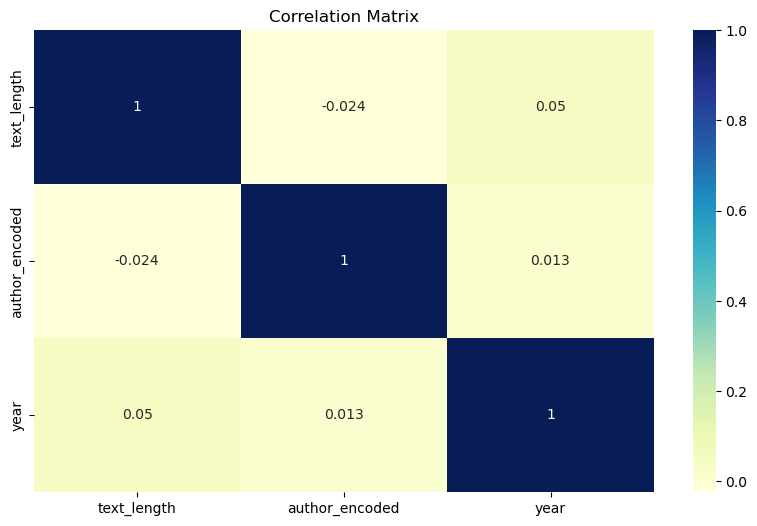

In [99]:
plt.figure(figsize=(10, 6))
sns.heatmap(data[['text_length', 'author_encoded', 'year']].corr(), annot=True, cmap='YlGnBu')
plt.title("Correlation Matrix")
plt.show()


## Pair Plot – Visualizing Feature Pairs

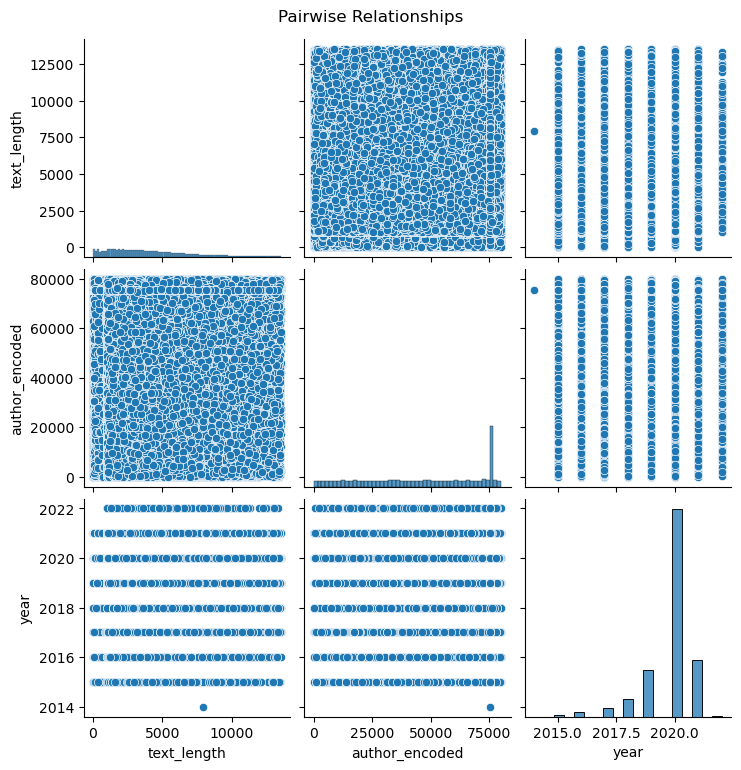

In [103]:
sns.pairplot(data[['text_length', 'author_encoded', 'year']])
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()


## Feature Engineering Breakdown

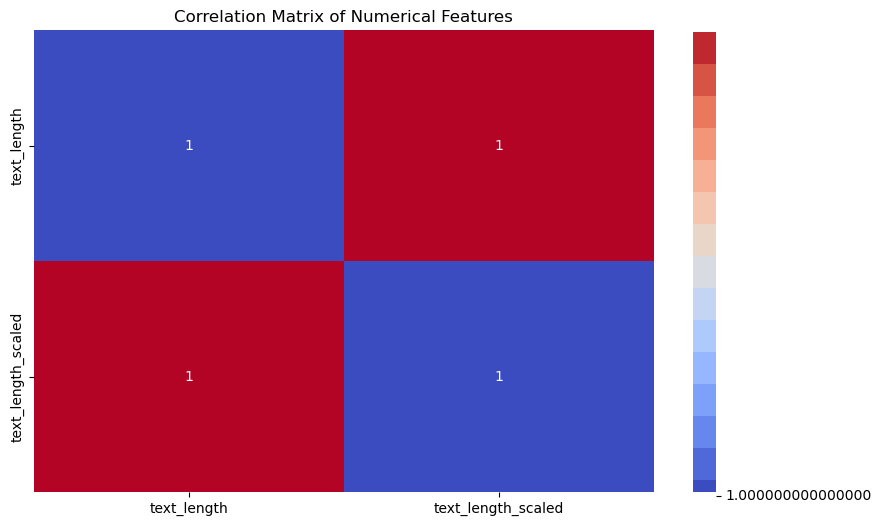

In [105]:
# Select only numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()



In [109]:
data[numeric_cols].var().sort_values(ascending=False)



text_length           9.277049e+06
text_length_scaled    1.000005e+00
dtype: float64